# This notebook shows two true-positive examples and two false-negivate examples of the Earthquake Transformer (EqT), and explains the motivation of the S-EqT method.

In [1]:
import sys
# set source code path here
sys.path.append('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/S_EqT_codes/src/')
import os
# set gpuid here
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import bisect
import warnings
warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model, Model
from EqT_libs.EqT_utils import DataGeneratorPrediction, picker, generate_arrays_from_file
from EqT_libs.EqT_utils import f1, SeqSelfAttention, FeedForward, LayerNormalization
from data_preprocessing import normalize_by_std

Using TensorFlow backend.


## Load the pre-trained EqT model

In [2]:
# This may take a while
EqT_model_path = '/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/models/EqT/EqT_model.h5'
EqT_model = load_model(EqT_model_path, 
               custom_objects={'SeqSelfAttention': SeqSelfAttention, 
                               'FeedForward': FeedForward,
                               'LayerNormalization': LayerNormalization, 
                               'f1': f1                                                                            
                                })

## Load and visualize example seismograms

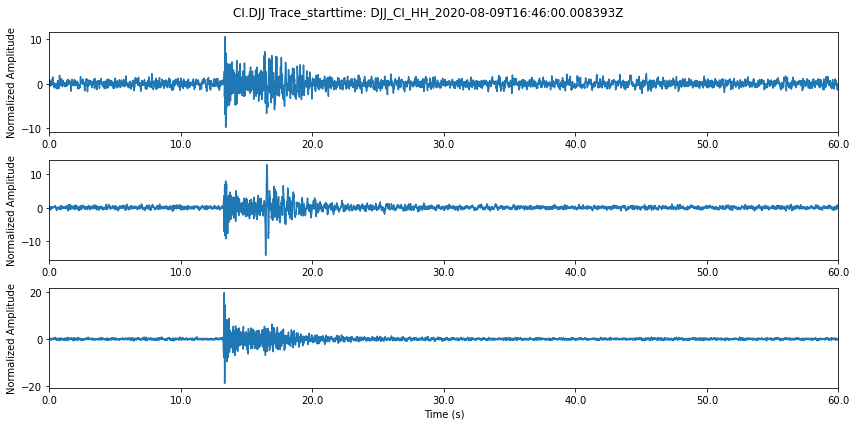

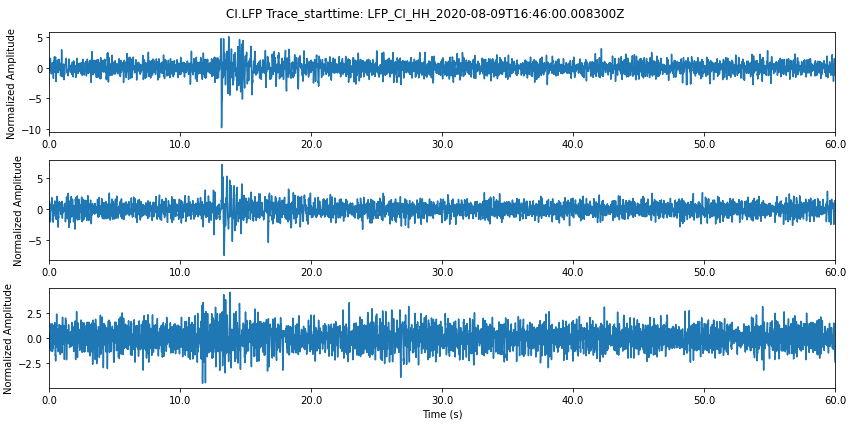

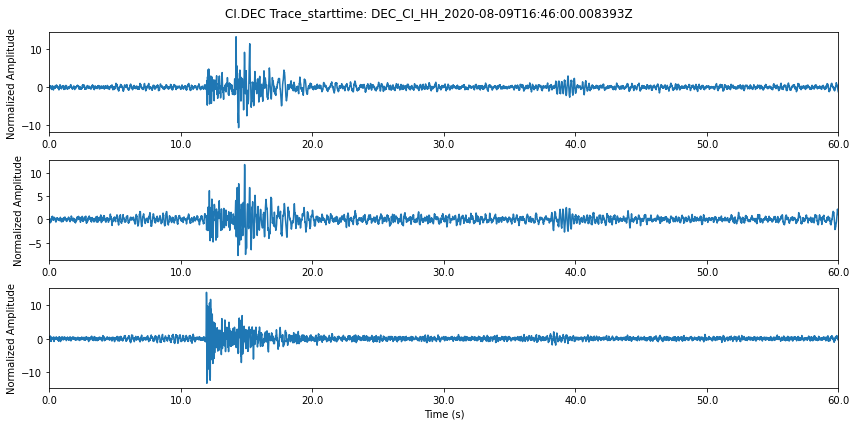

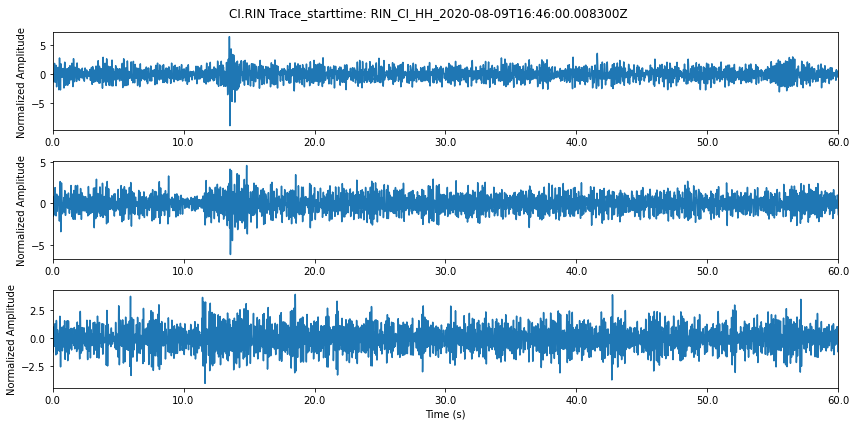

In [4]:
four_examples = np.load('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/Tutorial/01_explore_hidden_responses_in_the_pretrained_EqT/Four_examples.npy',allow_pickle=True)[()]
for key in four_examples.keys():
    plt.figure(figsize=(12,6))
    plt.suptitle('{} Trace_starttime: {}'.format(key, four_examples[key]['s_time']))
    for channel_dx in range(3):
        plt.subplot(3,1,channel_dx+1)
        plt.plot(four_examples[key]['data'][:,channel_dx])
        plt.ylabel('Normalized Amplitude')
        plt.xticks(np.arange(0,6001,1000),np.arange(0,60.01,10))
        plt.xlim([0,6000])
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()
    plt.close()

## Apply the pre-trained EqT model to these seismograms

In [5]:
for key in four_examples.keys():
    data_in = four_examples[key]['data']
    data_in = normalize_by_std(data_in)
    data_in_batch = np.zeros([1,6000,3])
    data_in_batch[0,:,:] = data_in[:,:]
    eqt_pred = EqT_model.predict(data_in_batch)
    four_examples[key]['EqT_prediction'] = eqt_pred

## Visualize EqT outputs

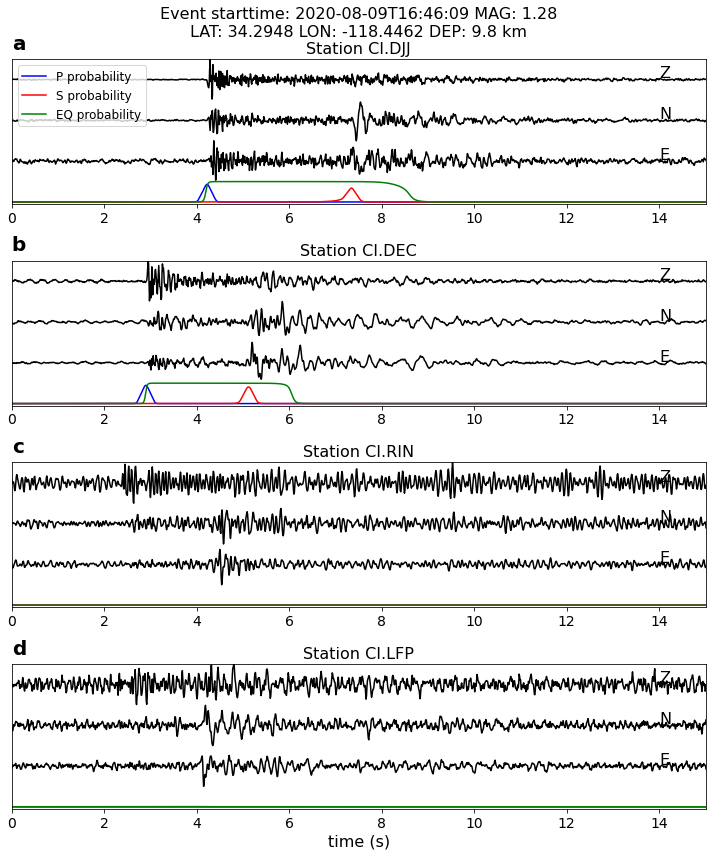

In [8]:
plt.figure(figsize=(10,12))
# plot params
start_sample_n = 900
end_sample_n = 2500
plot_t = np.arange(0,16.01,0.01)[:1600]

plt.subplot(4,1,1)
for idx in range(3):
    plt.plot(plot_t,four_examples['CI.DJJ']['data'][start_sample_n:end_sample_n,idx]/np.max(np.abs(four_examples['CI.DJJ']['data'][start_sample_n:end_sample_n,idx]))+idx*2 + 2,color='k')
    if idx == 0:
        plt.text(14, idx*2 + 2 + 0.1, 'E',fontsize=16)
    if idx == 1:
        plt.text(14, idx*2 + 2 + 0.1, 'N',fontsize=16)
    if idx == 2:
        plt.text(14, idx*2 + 2 + 0.1, 'Z',fontsize=16)
        
plt.plot(plot_t,four_examples['CI.DJJ']['EqT_prediction'][1][0,start_sample_n:end_sample_n,0],color='b',label='P probability')
plt.plot(plot_t,four_examples['CI.DJJ']['EqT_prediction'][2][0,start_sample_n:end_sample_n,0],color='r',label='S probability')
plt.plot(plot_t,four_examples['CI.DJJ']['EqT_prediction'][0][0,start_sample_n:end_sample_n,0],color='g',label='EQ probability')

plt.ylim([-0.1,7])
plt.yticks([])
plt.xticks(fontsize= 14) 
plt.title('Event starttime: 2020-08-09T16:46:09 MAG: 1.28\nLAT: 34.2948 LON: -118.4462 DEP: 9.8 km\nStation CI.DJJ',fontsize=16)
plt.legend(loc='upper left',prop= {'size':12})
plt.xlim([0,15])
plt.text(0,7.5,'a',fontsize=20,weight='bold')

plt.subplot(4,1,2)
for idx in range(3):
    plt.plot(plot_t,four_examples['CI.DEC']['data'][start_sample_n:end_sample_n,idx]/np.max(np.abs(four_examples['CI.DEC']['data'][start_sample_n:end_sample_n,idx]))+idx*2 + 2,color='k')
    if idx == 0:
        plt.text(14, idx*2 + 2 + 0.1, 'E',fontsize=16)
    if idx == 1:
        plt.text(14, idx*2 + 2 + 0.1, 'N',fontsize=16)
    if idx == 2:
        plt.text(14, idx*2 + 2 + 0.1, 'Z',fontsize=16)
        
plt.plot(plot_t,four_examples['CI.DEC']['EqT_prediction'][1][0,start_sample_n:end_sample_n,0],color='b',label='P prob')
plt.plot(plot_t,four_examples['CI.DEC']['EqT_prediction'][2][0,start_sample_n:end_sample_n,0],color='r',label='S prob')
plt.plot(plot_t,four_examples['CI.DEC']['EqT_prediction'][0][0,start_sample_n:end_sample_n,0],color='g',label='E prob')
plt.ylim([-0.1,7])
plt.xticks(fontsize= 14) 
plt.yticks([])
plt.title('Station CI.DEC',fontsize=16)
plt.xlim([0,15])
plt.text(0,7.5,'b',fontsize=20,weight='bold')


plt.subplot(4,1,3)
for idx in range(3):
    plt.plot(plot_t,four_examples['CI.RIN']['data'][start_sample_n:end_sample_n,idx]/np.max(np.abs(four_examples['CI.RIN']['data'][start_sample_n:end_sample_n,idx]))+idx*2 + 2,color='k')
    if idx == 0:
        plt.text(14, idx*2 + 2 + 0.1, 'E',fontsize=16)
    if idx == 1:
        plt.text(14, idx*2 + 2 + 0.1, 'N',fontsize=16)
    if idx == 2:
        plt.text(14, idx*2 + 2 + 0.1, 'Z',fontsize=16)
        
plt.plot(plot_t,four_examples['CI.RIN']['EqT_prediction'][1][0,start_sample_n:end_sample_n,0],color='b',label='P probability')
plt.plot(plot_t,four_examples['CI.RIN']['EqT_prediction'][2][0,start_sample_n:end_sample_n,0],color='r',label='S probability')
plt.plot(plot_t,four_examples['CI.RIN']['EqT_prediction'][0][0,start_sample_n:end_sample_n,0],color='g',label='EQ probability')
plt.ylim([-0.1,7])
plt.yticks([])
plt.xticks(fontsize= 14) 
plt.xlim([0,15])
plt.text(0,7.5,'c',fontsize=20,weight="bold")
plt.title('Station CI.RIN',fontsize=16)

plt.subplot(4,1,4)
for idx in range(3):
    plt.plot(plot_t,four_examples['CI.LFP']['data'][start_sample_n:end_sample_n,idx]/np.max(np.abs(four_examples['CI.LFP']['data'][start_sample_n:end_sample_n,idx]))+idx*2 + 2,color='k')
    if idx == 0:
        plt.text(14, idx*2 + 2 + 0.1, 'E',fontsize=16)
    if idx == 1:
        plt.text(14, idx*2 + 2 + 0.1, 'N',fontsize=16)
    if idx == 2:
        plt.text(14, idx*2 + 2 + 0.1, 'Z',fontsize=16)
plt.xlabel('time (s)',fontsize=16)        
plt.plot(plot_t,four_examples['CI.LFP']['EqT_prediction'][1][0,start_sample_n:end_sample_n,0],color='b',label='P prob')
plt.plot(plot_t,four_examples['CI.LFP']['EqT_prediction'][2][0,start_sample_n:end_sample_n,0],color='r',label='S prob')
plt.plot(plot_t,four_examples['CI.LFP']['EqT_prediction'][0][0,start_sample_n:end_sample_n,0],color='g',label='E prob')
plt.ylim([-0.1,7])
plt.yticks([])
plt.xticks(fontsize= 14) 
plt.xlim([0,15])
plt.text(0,7.5,'d',fontsize=20,weight="bold")
plt.title('Station CI.LFP',fontsize=16)
plt.tight_layout()
plt.show()
plt.close()

Note that **the EqT model is a powerful method for eartquake detection and phase picking and it has considerable performance in processsing low SNR seismograms (e.g., a two-fold increase in the Tottori earthquake case in Mousavi et al., 2020, Nature Communications).** This exmaple simply suggests that the EqT model has false negative issues in certian sitiuations and it can be further improved by leverging its hidden response among different stations.